In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Loading the publicly available Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

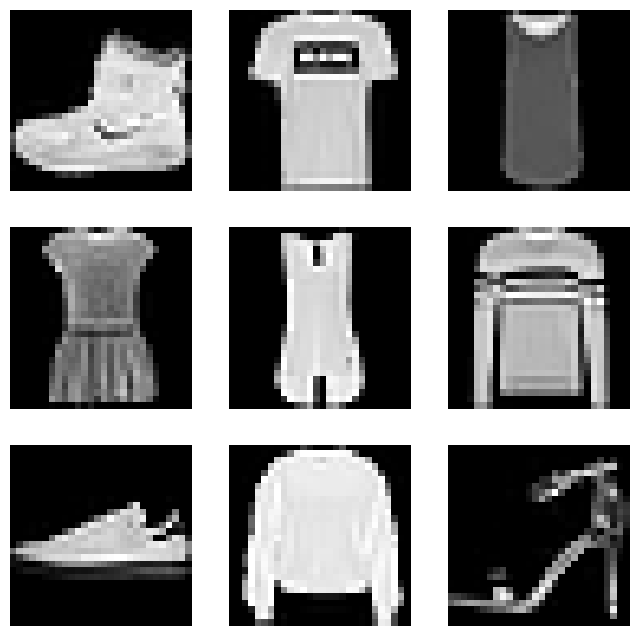

In [ ]:
# displaying the first ten images in a 3 by 3 grid
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

plt.show()


In [ ]:
print('Shape of training data : ', x_train.shape, y_train.shape)

Shape of training data :  (60000, 28, 28) (60000,)


In [ ]:
print('Shape of training data : ', x_test.shape, y_test.shape)

Shape of training data :  (10000, 28, 28) (10000,)


In [ ]:
# Since the pixels are in integer form, their type must be changed to float32, and their values must be rescaled to fall between 0 and 1.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
# Using the train labels to determine the unique numbers
classes = np.unique(y_train)
nClasses = len(classes)
print('The total count of outputs : ', nClasses)
print('Output categories : ', classes)

The total count of outputs :  10
Output categories :  [0 1 2 3 4 5 6 7 8 9]


## a. Use minimum of 3 convolutional layers in the encoder and 3 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

### Encoder

In [ ]:
# Specifying the input form
input_shape = (28, 28, 1)
# Defining the generator model's latent space's dimensions.
latent_size = 100

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)  # Additional Conv Layer
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
latent_space_mean = layers.Dense(latent_size)(x)
latent_space_log_var = layers.Dense(latent_size)(x)
encoder = keras.Model(encoder_inputs, [latent_space_mean, latent_space_log_var], name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

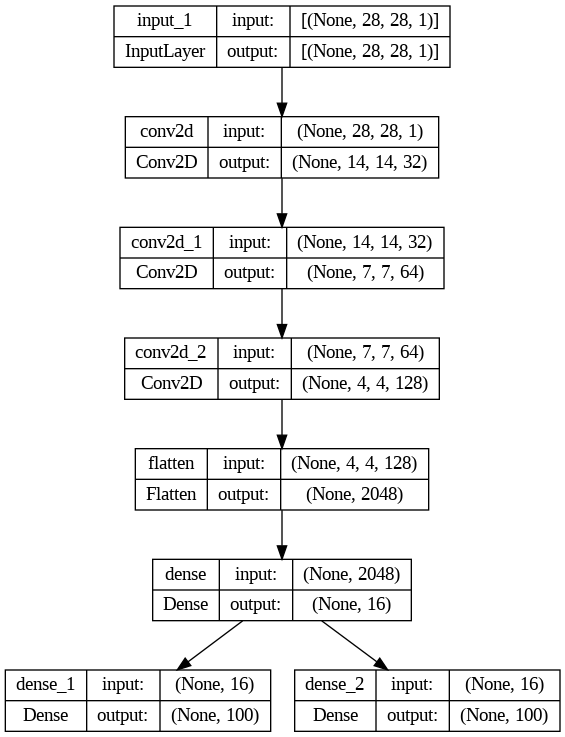

In [ ]:
plot_model(encoder, show_shapes=True)

### Decoder

In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(latent_size,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 3136)              316736    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

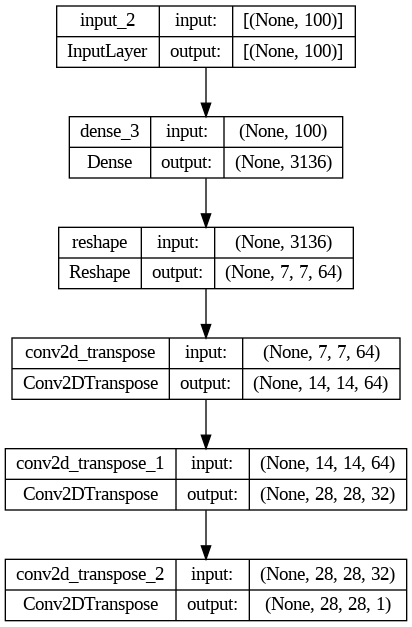

In [ ]:
plot_model(decoder, show_shapes=True)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        x, y = data
        y = tf.expand_dims(y, -1)
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_size))
            z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(y, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
def test_step(self, data):
        x, y = data
        y = tf.expand_dims(y, -1)
        z_mean, z_log_var = self.encoder(x)
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_size))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(y, reconstruction)
        )
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + kl_loss
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
#Initialising and putting together the VAE model
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam())


In [ ]:
# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(32)


In [ ]:
# Training the model with 25 epochs
history = vae_model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25
1875/1875 [==============================] - 21s 8ms/step - total_loss: 0.4402 - reconstruction_loss: 0.4108 - kl_loss: 0.0294 - val_total_loss: 0.4233 - val_reconstruction_loss: 0.3891 - val_kl_loss: 0.0342
Epoch 2/25
1875/1875 [==============================] - 15s 8ms/step - total_loss: 0.4041 - reconstruction_loss: 0.3678 - kl_loss: 0.0363 - val_total_loss: 0.3800 - val_reconstruction_loss: 0.3417 - val_kl_loss: 0.0383
Epoch 3/25
1875/1875 [==============================] - 15s 8ms/step - total_loss: 0.3861 - reconstruction_loss: 0.3501 - kl_loss: 0.0360 - val_total_loss: 0.3754 - val_reconstruction_loss: 0.3380 - val_kl_loss: 0.0374
Epoch 4/25
1875/1875 [==============================] - 15s 8ms/step - total_loss: 0.3817 - reconstruction_loss: 0.3447 - kl_loss: 0.0370 - val_total_loss: 0.3668 - val_reconstruction_loss: 0.3295 - val_kl_loss: 0.0373
Epoch 5/25
1875/1875 [==============================] - 16s 9ms/step - total_loss: 0.3783 - reconstruction_loss: 0.3399 - kl

 I implemented a Variational Autoencoder (VAE) using TensorFlow and Keras for image generation. The model consists of an encoder and a decoder. The encoder takes input images, applies a series of convolutional layers to extract features, and then maps the input to a latent space represented by mean and log-variance vectors. The decoder, on the other hand, generates output images from samples in the latent space.

The VAE is trained to reconstruct input images while also regularizing the latent space by incorporating a loss term related to the Kullback-Leibler divergence. During training, the model minimizes a combination of the reconstruction loss (measuring the fidelity of generated images to the originals) and the KL divergence loss (encouraging a structured and continuous latent space). The training process is carried out through stochastic gradient descent, optimizing the overall loss.

The custom VAE class extends the Keras Model class and defines the training and testing steps. Additionally, the code includes data preprocessing steps, such as loading and normalizing the Fashion MNIST dataset, and training the VAE on batches of data. The resulting VAE model is then compiled and trained for 25 epochs using the Adam optimizer.

Overall, this code establishes a VAE architecture for unsupervised learning, where the model learns a compact representation of the input data and demonstrates its ability to generate novel images in the latent space

## b. Display how the latent space clusters different classes of the training data.

313/313 [==============================] - 2s 4ms/step


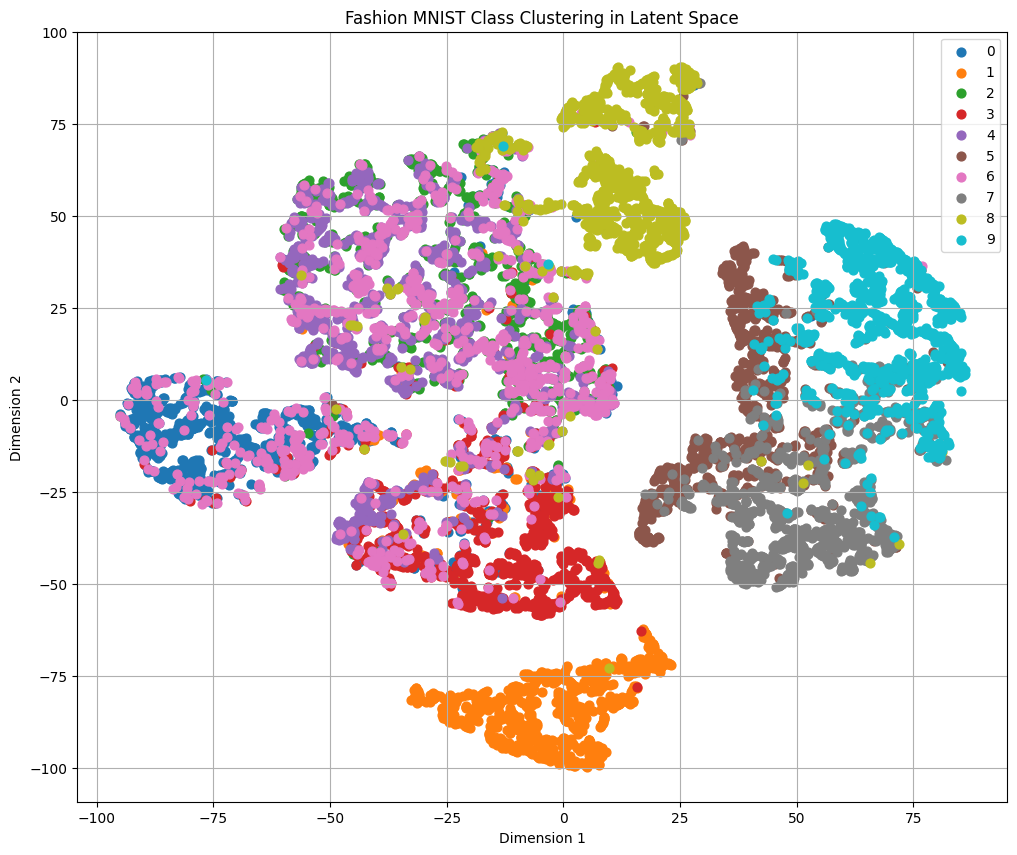

In [ ]:
def plot_label_clusters(encoder, data, labels, color_map='viridis', point_size=30, title='Clustered Visualization of Fashion MNIST Classes in Latent Space'):
    # Display a 2D plot of the digit classes in the latent space
    z_mean, _ = encoder.predict(data)
    z_embedded = TSNE(n_components=2).fit_transform(z_mean)

    plt.figure(figsize=(12, 10))
    for i in range(10):
        indices = np.where(labels == i)
        plt.scatter(z_embedded[indices, 0], z_embedded[indices, 1], label=str(i), cmap=color_map, s=point_size)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.show()

# Example usage with a more specific title
plot_label_clusters(encoder, x_test, y_test, color_map='plasma', point_size=40, title='Fashion MNIST Class Clustering in Latent Space')


1875/1875 [==============================] - 5s 3ms/step


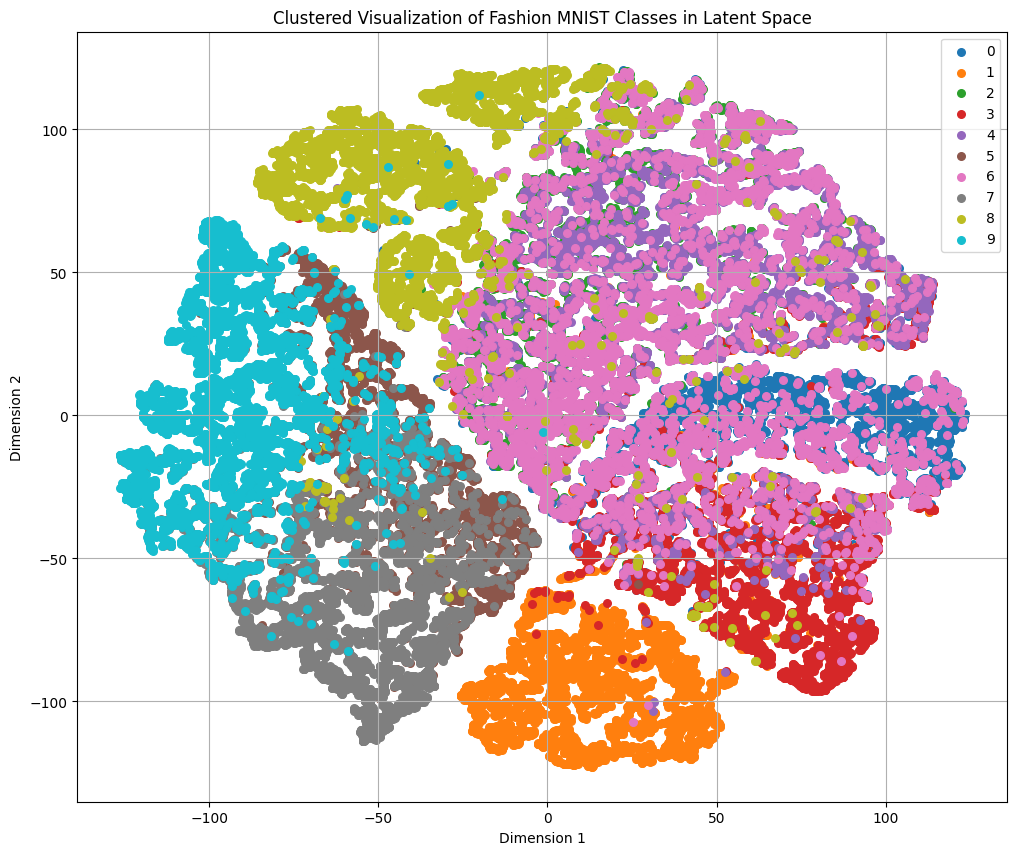

In [ ]:
plot_label_clusters(encoder, x_train, y_train)

313/313 [==============================] - 1s 2ms/step


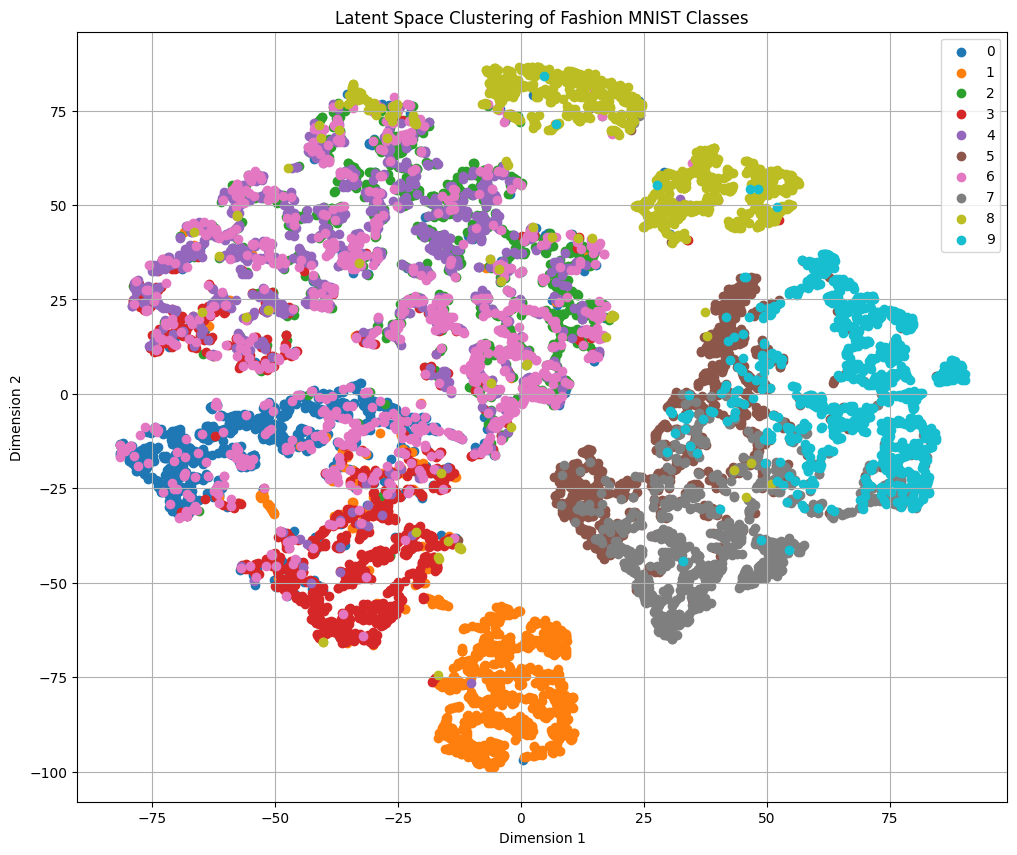

In [ ]:
plot_label_clusters(encoder, x_test, y_test)

The visualizations here represent a clustered view of the Fashion MNIST dataset within a latent space constructed by a Variational Autoencoder. Each point in the plots corresponds to a compressed representation of a fashion item, and the colors denote different classes of items, such as trousers, shirts, dresses, etc.

As we can see, certain classes are well-separated into distinct clusters, demonstrating that the VAE can discern between these different types of items effectively. This is evident in the formation of tight and non-overlapping clusters. However, there is also a degree of overlap between some classes, especially where the visual characteristics of certain fashion items are similar, which presents an area for further improvement.

The dimensionality reduction to two dimensions for the purpose of visualization might contribute to the observed overlap. The true latent space is multidimensional, and the overlapping clusters in 2D may actually be more separated in higher dimensions.

#Problem 2 (2+ 8 = 10 pts): Use the IMDB Movie review dataset:

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#importing the IMDB
df= pd.read_csv(r"/content/IMDB Dataset.csv")

In [ ]:
# Displaying the original DataFrame
print("The initial dataframe without preprocessing:")
df

The initial dataframe without preprocessing:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Perform Text Preprocessing
a. Tokenization
b. Stopwords removing
c. HTML removing
d. Convert to lower case
e. Lemmatization/stemming



In [ ]:
# Preprocessing Text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    # Tokenization (Question a)
    words = text.split()
    # Stopwords removal (Question b)
    meaningful_words = [w for w in words if w.lower() not in stop_words]
    # Convert to lower case (Question d)
    lower_case_text = " ".join(meaningful_words).lower()
    # HTML removing (Question c)
    text_no_html = BeautifulSoup(lower_case_text, "html.parser").get_text()
    # Lemmatization (Question e)
    lemmatized_words = [lemmatizer.lemmatize(w) for w in text_no_html.split()]
    return " ".join(lemmatized_words)

In [ ]:
# Apply preprocessing to the 'review' column and create a new column 'processed_review'
df['processed_review'] = df['review'].astype(str).apply(preprocess_text)

In [ ]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production. the filming techn...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there's family little boy (jake) thi...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love time money"" visually stu..."


## Build the following sentiment analysis models and create a performance comparison table:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

### a. TF-IDF + GausianNB


In [ ]:
# Sentiment Analysis Models
# a. TF-IDF + GaussianNB
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_review']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# Since GaussianNB expects the input to be dense, we do not need to transform it further
gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_train, y_train)
y_pred_tfidf = gnb_tfidf.predict(X_test)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

In [ ]:
# Calculating other performance metrics
precision_tfidf = precision_score(y_test, y_pred_tfidf)
recall_tfidf = recall_score(y_test, y_pred_tfidf)
f1_score_tfidf = f1_score(y_test, y_pred_tfidf)

### b. Word2Vec (CBoW) + GausianNB

In [ ]:
# b. Word2Vec (CBoW) + GaussianNB
# Tokenization for Word2Vec
def tokenize_text(text):
    return simple_preprocess(text, deacc=True)

df['tokenized_review'] = df['processed_review'].apply(tokenize_text)

# Build Word2Vec Model
w2v_model = Word2Vec(sentences=df['tokenized_review'], vector_size=100, window=5, min_count=5, workers=4)
w2v_model.train(df['tokenized_review'], total_examples=len(df['tokenized_review']), epochs=50)

(292280748, 311197950)

In [ ]:
# Function to vectorize a text
def document_vector(word2vec_model, doc):
    # removing out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[doc], axis=0)

In [ ]:
# Vectorize the reviews
X_w2v = np.array([document_vector(w2v_model, doc) for doc in df['tokenized_review']])

In [ ]:
# Split the data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [ ]:
gnb_w2v = GaussianNB()
gnb_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = gnb_w2v.predict(X_test_w2v)
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)

In [47]:
precision_w2v = precision_score(y_test, y_pred_w2v)
recall_w2v = recall_score(y_test, y_pred_w2v)
f1_score_w2v = f1_score(y_test, y_pred_w2v)

#c. Glove + GausianNB

In [ ]:
# Load GloVe vectors into a dictionary:
def load_glove_model(glove_input_file):
    word_embeddings = {}
    with open(glove_input_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = coefs
    return word_embeddings

In [ ]:
# Under the assumption that 'glove.6B.50d.txt' contains GloVe vectors
glove_vectors = load_glove_model(r'/content/glove.twitter.27B.100d.txt')


In [ ]:
# Function to create an averaged word vector for a document:
def document_vector_glove(doc):
    words = word_tokenize(doc)
    # removing out-of-vocabulary words
    doc = [word for word in words if word in glove_vectors]
    if len(doc) == 0:
        return np.zeros(50)
    else:
        return np.mean(np.array([glove_vectors[word] for word in doc]), axis=0)

In [ ]:
# Vectorizing the reviews
X_glove = np.array([document_vector_glove(review) for review in df['processed_review']])

In [48]:
# Target variable
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [49]:
# Split the data
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y, test_size=0.2, random_state=42)

In [50]:
# Train GaussianNB Model
gnb_glove = GaussianNB()
gnb_glove.fit(X_train_glove, y_train_glove)
y_pred_glove = gnb_glove.predict(X_test_glove)

In [51]:
# Evaluate the model
accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)

In [52]:
precision_glove = precision_score(y_test, y_pred_glove)
recall_glove = recall_score(y_test, y_pred_glove)
f1_score_glove = f1_score(y_test, y_pred_glove)

#Models comparision

In [53]:
performance_data = {
    'Model': ['TF-IDF + GNB', 'Word2Vec (CBoW) + GNB', 'GloVe + GNB'],
    'Accuracy': [accuracy_tfidf, accuracy_w2v, accuracy_glove],
    'Precision': [precision_tfidf, precision_w2v, precision_glove],
    'Recall': [recall_tfidf, recall_w2v, recall_glove],
    'F1 score': [f1_score_tfidf, f1_score_w2v, f1_score_glove]}

In [54]:
print(performance_data)

{'Model': ['TF-IDF + GNB', 'Word2Vec (CBoW) + GNB', 'GloVe + GNB'], 'Accuracy': [0.7963, 0.7659, 0.7163], 'Precision': [0.8027430415490117, 0.7744100895036615, 0.7355584082156611], 'Recall': [0.7898392538202024, 0.7555070450486208, 0.6822782298075015], 'F1 score': [0.7962388716614983, 0.7648417880462078, 0.7079172243385153]}


In [55]:
# Creating a DataFrame using the performance data
performance_comparison_table = pd.DataFrame(performance_data)

# Displaying the DataFrame
print(performance_comparison_table)

                   Model  Accuracy  Precision    Recall  F1 score
0           TF-IDF + GNB    0.7963   0.802743  0.789839  0.796239
1  Word2Vec (CBoW) + GNB    0.7659   0.774410  0.755507  0.764842
2            GloVe + GNB    0.7163   0.735558  0.682278  0.707917


<Axes: xlabel='Model', ylabel='Accuracy'>

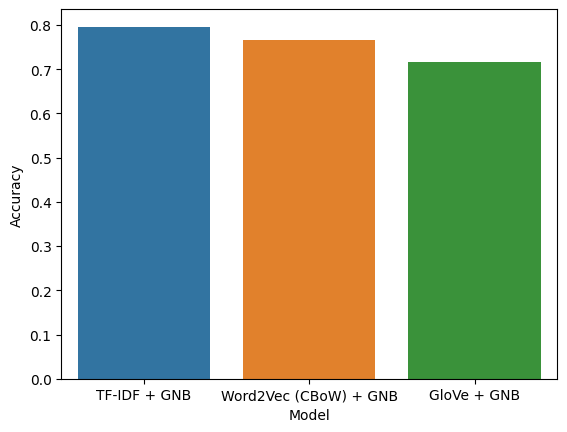

In [56]:
sns.barplot(data=performance_comparison_table, x= 'Model', y='Accuracy' )

#BONUS (2 pts): Write in your own words what is Byte Pair Encoding (BPE) and mentioned the steps involved in BPE tokenization. Apply Byte Pair Encoding (BPE) for 5%, 10%, 15% and 20% of the IMDB training dataset. Compare the BPE in terms of number of generated tokens for the varying datasets.

In [ ]:
pip install tokenizers

Byte Pair Encoding (BPE) is a versatile compression algorithm widely used in natural language processing, especially for tasks like language modeling and machine translation. In the context of tokenization, BPE begins by initializing a vocabulary with individual characters or subwords, assigning frequencies to each unique unit in the dataset.

This algorithm then iteratively calculates the frequency of consecutive unit pairs, merging the most frequent pair into a new unit. This process continues until a predefined vocabulary size is achieved. Once the vocabulary is fixed, the dataset undergoes tokenization using the learned units.

The code I did below applies BPE to different portions (5%, 10%, 15%, and 20%) of the IMDB training dataset, showcasing how the number of tokens evolves with varying dataset sizes. This practical application provides valuable insights into how tokenization responds to diverse training data volumes, shedding light on the intricate relationship between dataset size and the resulting vocabulary complexity. The resulting comparison DataFrame quantifies the impact of dataset size on BPE tokenization, offering a clear numerical assessment.

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import pandas as pd

# Preparing your dataset
reviews = df['review'].tolist()

# Defining the sizes for the portions of your dataset
portion_sizes = [0.05, 0.1, 0.15, 0.2]

# Dictionary to hold the number of tokens for each portion size
tokens_count_dict = {}

for portion in portion_sizes:
    # Calculate the actual size of the portion
    portion_size = int(len(reviews) * portion)

    # Initializing a tokenizer like above
    bpe_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    bpe_tokenizer.pre_tokenizer = Whitespace()

    # Creating a trainer
    bpe_trainer = BpeTrainer(vocab_size=30000, min_frequency=2, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

    # Training the tokenizer
    bpe_tokenizer.train_from_iterator(reviews[:portion_size], trainer=bpe_trainer)

    # Tokenizing the dataset portion
    encoded_output = bpe_tokenizer.encode_batch(reviews[:portion_size])

    # Calculating the number of tokens in the tokenized dataset
    num_tokens = sum([len(output.tokens) for output in encoded_output])
    tokens_count_dict[f"{int(portion*100)}%"] = num_tokens

    # Printing the number of tokens to show how it works
    print(f"For {int(portion*100)}% of the dataset, the token count is: {num_tokens}")


# Creating a DataFrame to compare the number of tokens
comparison_df = pd.DataFrame(list(tokens_count_dict.items()), columns=['Dataset Portion', 'Number of Tokens'])

print(comparison_df)

For 5% of the dataset, the token count is: 709849
For 10% of the dataset, the token count is: 1445223
For 15% of the dataset, the token count is: 2180697
For 20% of the dataset, the token count is: 2899546
  Dataset Portion  Number of Tokens
0              5%            709849
1             10%           1445223
2             15%           2180697
3             20%           2899546
